In [1]:
import sys
import cv2
import torch
from pathlib import Path

sys.path.append(str(Path("..").joinpath("src").absolute().resolve()))

In [2]:
# Define filepath
fp = Path("34d3d5ef-b98f-46e1-b481-2249752423c4.mp4")

# Open video capture
cap = cv2.VideoCapture(fp)

# Load frames
frames_xy = []
while True:
    flag, frame = cap.read()
    if not flag: break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = torch.from_numpy(frame)
    frames_xy.append(frame)
frames_xy = torch.stack(frames_xy, dim=0)

In [3]:
# 3D landmark detection using the MediaPipe FaceMesh pipeline
from orientation_uv_rppg.utils.landmark_detector import MediaPipeLandmarkDetector

detector = MediaPipeLandmarkDetector()
landmarks_xyz = detector(frames_xy)
landmarks_xyz.shape # >>> [T,V,3]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1755062002.082684  714476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1755062002.105074  714476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1755062002.109693  714490 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


torch.Size([228, 468, 3])

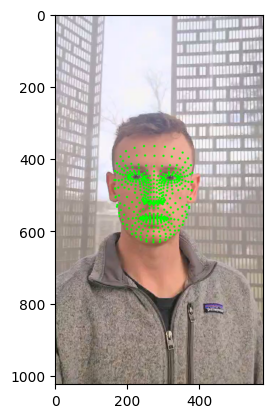

In [4]:
import cv2
import numpy as np

def draw_landmarks_on_frames(frames, landmarks, radius=3, color=(0, 255, 0), thickness=-1):
    """
    Draw landmarks on frames using OpenCV.
    
    Args:
        frames: numpy array of shape [N, H, W, C] - input frames
        landmarks: numpy array of shape [N, V, 3] - landmarks (using only x,y)
        radius: int - radius of the landmark circles
        color: tuple - BGR color for the landmarks (default: green)
        thickness: int - thickness of circle (-1 for filled)
    
    Returns:
        numpy array of shape [N, H, W, C] - frames with landmarks drawn
    """
    # Make a copy to avoid modifying original frames
    frames_with_landmarks = frames.copy()
    
    N, H, W, C = frames.shape
    N_landmarks, V, _ = landmarks.shape
    
    # Ensure we have matching number of frames and landmark sets
    assert N == N_landmarks, f"Number of frames ({N}) must match number of landmark sets ({N_landmarks})"
    
    for frame_idx in range(N):
        frame = frames_with_landmarks[frame_idx]
        frame_landmarks = landmarks[frame_idx]
        
        for landmark_idx in range(V):
            # Extract x, y coordinates (ignore z)
            x, y = frame_landmarks[landmark_idx, :2]
            
            # Convert to integers for pixel coordinates
            x, y = int(round(x)), int(round(y))
            
            # Check if landmark is within frame bounds
            if 0 <= x < W and 0 <= y < H:
                cv2.circle(frame, (x, y), radius, color, thickness)
    
    return frames_with_landmarks

frames_with_landmarks = draw_landmarks_on_frames(frames_xy.cpu().numpy(), landmarks_xyz.cpu().numpy())

import matplotlib.pyplot as plt
plt.imshow(frames_with_landmarks[0])

In [5]:
# Piece-wise affine transformation of frames from XY (image-space) to UV (texture-space)
from orientation_uv_rppg.utils.frame_warp import GPUPiecewiseAffineTransform

device = "cuda" if torch.cuda.is_available() else "cpu"
frames_xy = frames_xy.to(device)
landmarks_xyz = landmarks_xyz.to(device)

warper = GPUPiecewiseAffineTransform(detector.landmarks_uv, device=device)
frames_uv = warper(frames_xy, landmarks_xyz, output_size=64)
frames_uv.shape # >>> [T,64,64,C]

torch.Size([228, 64, 64, 3])

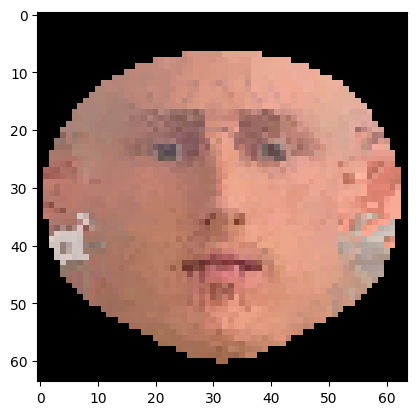

In [6]:
plt.imshow(frames_uv[0].cpu())

In [7]:
# UV (texture-space) frame masking based on surface orientation relative to camera
from orientation_uv_rppg.utils.frame_mask import UVAngleMasker

masker = UVAngleMasker(detector.mesh_faces)
frames_uv_masked = masker(frames_uv, detector.landmarks_uv, landmarks_xyz, degree_threshold=60.0)
frames_uv_masked.shape # >>> [T,64,64,C]

torch.Size([228, 64, 64, 3])

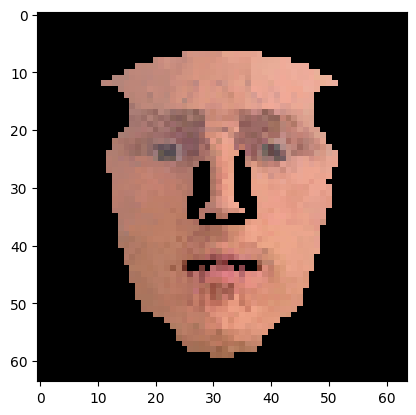

In [8]:
plt.imshow(frames_uv_masked[0].cpu())